# Question 02

In [2]:
pip install tikzplotlib

  Using cached tikzplotlib-0.10.1-py3-none-any.whl.metadata (8.9 kB)
Using cached tikzplotlib-0.10.1-py3-none-any.whl (54 kB)

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


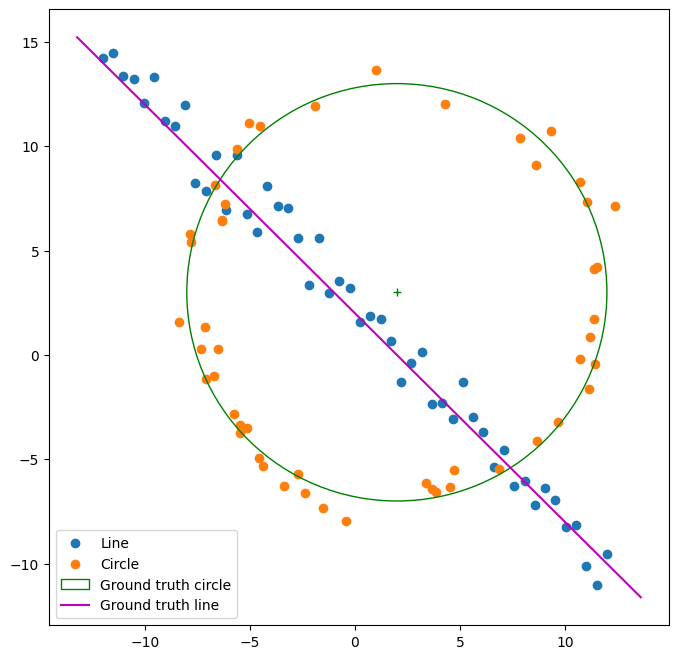

In [9]:
from scipy.optimize import minimize
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center 
s = r / 16

t = np.random.uniform(0, 2*np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)

X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s * np.random.randn(half_n)

X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()




# Q02 a)
# RANSAC Estimation for Line

Iteration 0: res.x = [ 0.99730237 -0.07340325 -4.18874127], inliers count = 8
Iteration 1: res.x = [ 0.9414585  -0.33712891 -3.64579168], inliers count = 8
Iteration 2: res.x = [ 9.99992770e-01 -3.80847147e-03 -6.69681687e+00], inliers count = 14
Iteration 3: res.x = [-0.28600965  0.95822674 -7.21549794], inliers count = 13
Iteration 4: res.x = [0.59888878 0.80083221 0.31352988], inliers count = 20
Iteration 5: res.x = [ 0.94069615 -0.33925029 -4.43389236], inliers count = 8
Iteration 6: res.x = [ 0.81121885  0.58474267 -6.41259055], inliers count = 14
Iteration 7: res.x = [0.7558516  0.65474361 2.14777374], inliers count = 37
Iteration 8: res.x = [ 0.57661855 -0.81701361  4.02234538], inliers count = 8
Iteration 9: res.x = [ 0.95222105 -0.30540989 -0.25553721], inliers count = 7
Iteration 10: res.x = [ 0.68213024 -0.73123096 -9.29726896], inliers count = 10
Iteration 11: res.x = [0.69818331 0.71591904 0.85421938], inliers count = 36
Iteration 12: res.x = [0.91260906 0.40883335 0.73494

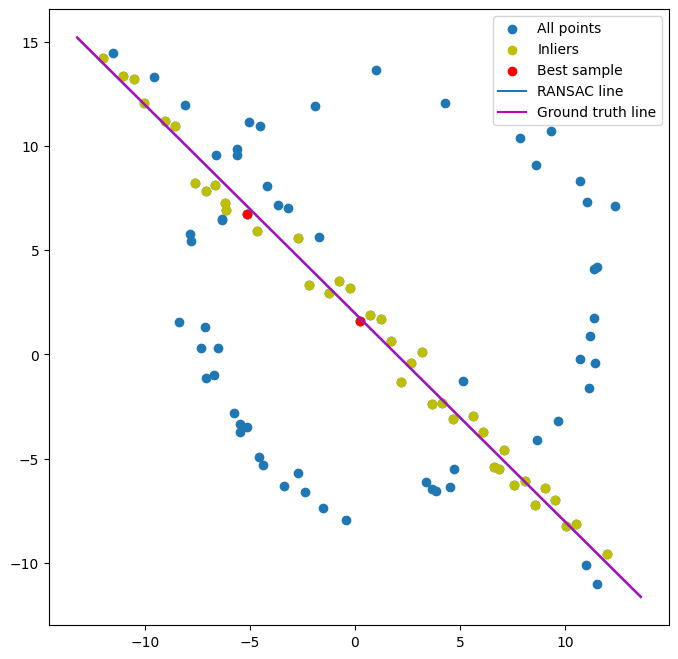

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

N = X.shape[0]
X_ = X

def compute_line_params(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# Function to calculate total least squares for a line
def total_least_squares(x, indices):
    a, b, d = x
    return np.sum((a * X_[indices, 0] + b * X_[indices, 1] - d) ** 2)

def circle_constraint(x):
    return x[0]**2 + x[1]**2 - 1

constraints = ({'type': 'eq', 'fun': circle_constraint})

# Determine inliers 
def find_inliers(X_, model_params, threshold):
    a, b, d = model_params
    errors = np.abs(a * X_[:, 0] + b * X_[:, 1] - d)
    return errors < threshold

# Parameters
threshold = 1
required_inliers_count = 0.4 * N
sample_size = 2
max_iter = 50

best_model = None
best_error = np.inf
best_inliers = None
best_sample = None
res_with_sample = None

for iteration in range(max_iter):
    indices = np.random.randint(0, N, sample_size)
    initial_guess = np.array([1, 1, 0])
    
    # Optimize model parameters
    result = minimize(total_least_squares, initial_guess, args=(indices,), 
                      constraints=constraints, tol=1e-6, options={'disp': False})
    
    inliers = find_inliers(X_, result.x, threshold)
    print(f'Iteration {iteration}: res.x = {result.x}, inliers count = {inliers.sum()}')

    if inliers.sum() > required_inliers_count:
        new_initial_guess = result.x
        # Optimize using all inliers
        result = minimize(total_least_squares, new_initial_guess, args=(inliers,), 
                          constraints=constraints, tol=1e-6, options={'disp': False})
        
        if result.fun < best_error:
            print(f"A better model is found: {result.x}, Error: {result.fun}")
            best_model = result.x
            best_error = result.fun
            best_sample = X_[indices, :]  # Save best sample points
            res_with_sample = new_initial_guess  # Store result from best sample
            best_inliers = inliers

print("Best line model:", best_model)
print("Best sample points:", best_sample)



# Plotting results
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_[:, 0], X_[:, 1], label='All points')
ax.scatter(X_[best_inliers, 0], X_[best_inliers, 1], color='y', label='Inliers')
ax.scatter(best_sample[:, 0], best_sample[:, 1], color='r', label='Best sample')

# Calculate and plot the RANSAC line
x_min, x_max = ax.get_xlim()
x_values = np.array([x_min, x_max])
y_values = (-best_model[1] * x_values + best_model[2]) / best_model[1]
plt.plot(x_values, y_values, label='RANSAC line')

# Calculate and plot the ground truth line
y_ground_truth = m * x_values + b
plt.plot(x_values, y_ground_truth, color='m', label='Ground truth line')

plt.legend()
plt.show()


# Q02 b)
# RANSAC Estimation for Circle

In [11]:
# Get the indices of the inliers
inlier_indices = np.where(best_inliers)[0]

# Subtracting the consensus of the best line (removing inliers)
remnant_indices = np.setdiff1d(np.arange(100), inlier_indices)

# Extracting the remnant points
X_circ = X[remnant_indices]
N = X_circ.shape[0]

def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    d = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / d
    uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / d
    r = np.sqrt(ux**2 + uy**2 + ((x1**2 + y1**2) * (x2 * y3 - x3 * y2) + (x2**2 + y2**2) * (x3 * y1 - x1 * y3) + (x3**2 + y3**2) * (x1 * y2 - x2 * y1)) / d)
    return ux, uy, r

# RANSAC to fit a circle
def circle_tls(x, indices):
    ux, uy, r = x[0], x[1], x[2]
    radial_errors = np.abs(np.sqrt((X_circ[indices, 0] - ux)**2 + (X_circ[indices, 1] - uy)**2) - r)
    return np.sum(np.square(radial_errors))


def consensus_circle(X, x, t):
    ux, uy, r = x[0], x[1], x[2]
    radial_error = np.abs(np.sqrt((X[:, 0] - ux)**2 + (X[:, 1] - uy)**2) - r)
    return radial_error < t

# Constraint for circle parameters
def h(x):
    return x[2] - 10

circle_cons = ({'type': 'ineq', 'fun': h})

# Threshold value to determine inliers (radial error)
t_circle = 1.0

# Number of close data points required to assert that a model fits well to data (circle)
d_circle = 0.7 * X_circ.shape[0]

inliers_circle = []
best_model_circle = []
best_inliers_circle = []
best_error_circle = np.inf
best_sample_circle = []

iteration = 0
maX_circiterations_circle = 50

s_circle = 3

while iteration < maX_circiterations_circle:
    indices_circ = np.random.randint(0,N, s_circle)
    x0_circle = circle_equation_from_points(X_circ[indices_circ[0], 0], X_circ[indices_circ[0], 1], X_circ[indices_circ[1], 0], X_circ[indices_circ[1], 1], X_circ[indices_circ[2], 0], X_circ[indices_circ[2], 1])
    res_circle = minimize(fun=circle_tls, args=(inliers_circle), x0=x0_circle, tol=1e-6, constraints=circle_cons)
    inliers_circle = consensus_circle(X_circ, res_circle.x, t_circle)
    print(f'Circle Iteration {iteration}, No. inliers = {inliers_circle.sum()}')
    if inliers_circle.sum() > d_circle:
        x0_circle = res_circle.x
        res_circle = minimize(fun=circle_tls, args=(inliers_circle), x0=x0_circle, tol=1e-6, constraints=circle_cons)
        if res_circle.fun < best_error_circle:
            print('A better model found ... ', res_circle.x, res_circle.fun)
            best_model_circle = res_circle.x
            best_error_circle = res_circle.fun
            best_inliers_circle = inliers_circle
            best_sample_circle = X_circ[indices_circ,:]
    iteration += 1

Circle Iteration 0, No. inliers = 2
Circle Iteration 1, No. inliers = 41
Circle Iteration 2, No. inliers = 43
A better model found ...  [ 1.76945423  3.09954795 10.        ] 8.988187376561413
Circle Iteration 3, No. inliers = 44
Circle Iteration 4, No. inliers = 44
Circle Iteration 5, No. inliers = 44
Circle Iteration 6, No. inliers = 44
Circle Iteration 7, No. inliers = 44
Circle Iteration 8, No. inliers = 44
Circle Iteration 9, No. inliers = 44
Circle Iteration 10, No. inliers = 44
Circle Iteration 11, No. inliers = 44
Circle Iteration 12, No. inliers = 44
Circle Iteration 13, No. inliers = 44
Circle Iteration 14, No. inliers = 0
Circle Iteration 15, No. inliers = 29
Circle Iteration 16, No. inliers = 39
Circle Iteration 17, No. inliers = 42
A better model found ...  [ 1.72881907  3.09386457 10.        ] 8.055305830637748
Circle Iteration 18, No. inliers = 44
Circle Iteration 19, No. inliers = 44
Circle Iteration 20, No. inliers = 44
Circle Iteration 21, No. inliers = 44
Circle Itera

/var/folders/x4/rfns4_cd6f17r07t7gy7kc3w0000gn/T/ipykernel_27996/3427791496.py:13: RuntimeWarning: invalid value encountered in scalar divide
  ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / d
/var/folders/x4/rfns4_cd6f17r07t7gy7kc3w0000gn/T/ipykernel_27996/3427791496.py:14: RuntimeWarning: invalid value encountered in scalar divide
  uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / d
/var/folders/x4/rfns4_cd6f17r07t7gy7kc3w0000gn/T/ipykernel_27996/3427791496.py:15: RuntimeWarning: invalid value encountered in scalar divide
  r = np.sqrt(ux**2 + uy**2 + ((x1**2 + y1**2) * (x2 * y3 - x3 * y2) + (x2**2 + y2**2) * (x3 * y1 - x1 * y3) + (x3**2 + y3**2) * (x1 * y2 - x2 * y1)) / d)


In [22]:
# # Assuming best_model_circle contains [ux, uy, r]
# ux, uy, r = best_model_circle

# # Plotting the points
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# ax.scatter(X[:, 0], X[:, 1], label='All points')

# ax.scatter(X_[best_inliers,0],X_[best_inliers,1], color='c', label='Inliers Line')
# ax.scatter(best_sample[:,0],best_sample[:,1], color='lightcoral', label='Best sample line')
# x_min, x_max = ax.get_xlim()
# x_ = np.array([x_min, x_max])
# y_ = (-best_model[1]*x_ + best_model[2])/best_model[1]
# plt.plot(x_, y_,  label='RANSAC line')
# x_ = np.array([x_min, x_max])
# y_ = m*x_ + b
# plt.plot(x_, y_, color='m', label='Ground truth line')

# ax.scatter(X_circ[best_inliers_circle, 0], X_circ[best_inliers_circle, 1], color='y', label='Inliers Circle')
# ax.scatter(best_sample_circle[:, 0], best_sample_circle[:, 1], color='r', label='Best sample circle')



# # Plotting the RANSAC circle
# circle_ransac = plt.Circle((ux, uy), r, color='g', fill=False, label='RANSAC Circle')
# ax.add_patch(circle_ransac)

# # Plotting the ground truth circle
# circle_gt = plt.Circle((x0_gt, y0_gt), r, color='b', fill=False, label='Ground Truth Circle')
# ax.add_patch(circle_gt)

# # Set the aspect of the plot to be equal
# ax.set_aspect('equal', 'box')

# # Set limits and labels
# ax.set_xlim(-15, 15)
# ax.set_ylim(-15, 15)
# plt.xlabel('X')
# plt.ylabel('Y')

# plt.legend()
# plt.show()


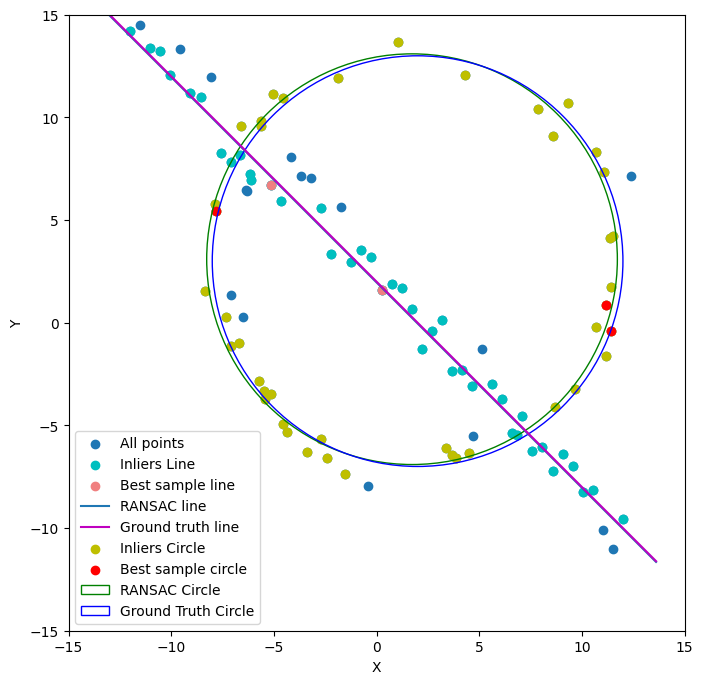

In [23]:
ux, uy, r = best_model_circle

# Plotting the points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot all points
ax.scatter(X[:, 0], X[:, 1], label='All points')

# Plot inliers line
ax.scatter(X_[best_inliers, 0], X_[best_inliers, 1], color='c', label='Inliers Line')

# Plot best sample line
ax.scatter(best_sample[:, 0], best_sample[:, 1], color='lightcoral', label='Best sample line')

# Calculate RANSAC line coordinates
x_min, x_max = ax.get_xlim()
x_ = np.linspace(x_min, x_max, 100)
y_ = (-best_model[1] * x_ + best_model[2]) / best_model[1]
plt.plot(x_, y_, label='RANSAC line')

# Calculate and plot ground truth line
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

# Plot inliers circle
ax.scatter(X_circ[best_inliers_circle, 0], X_circ[best_inliers_circle, 1], color='y', label='Inliers Circle')

# Plot best sample circle
ax.scatter(best_sample_circle[:, 0], best_sample_circle[:, 1], color='r', label='Best sample circle')

# Plotting the RANSAC circle
circle_ransac = plt.Circle((ux, uy), r, color='g', fill=False, label='RANSAC Circle')
ax.add_patch(circle_ransac)

# Plotting the ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='b', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)

# Set the aspect of the plot to be equal
ax.set_aspect('equal', 'box')

# Set limits and labels
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
plt.xlabel('X')
plt.ylabel('Y')

plt.legend()
plt.show()
